# Модуль Б. Разработка модели машинного обучения

## Импортирование библиотек

In [172]:
# 
import zipfile

#
from ultralytics import YOLO

# 
import pandas as pd

#
import numpy as np

#
import matplotlib.pyplot as plt
%matplotlib inline

#
import os

# 
from deepface import DeepFace

#
import torch

#
import cv2

# 
import numpy as np

#
from PIL import Image

#
from tqdm import tqdm

In [2]:
# назначаем основные пути
module_dir = os.getcwd()
main_dir = module_dir[:-8]
data_dir = os.path.join(main_dir, r'Module1\Data')
# логирование
print(os.path.exists(main_dir))
print(os.path.exists(data_dir))
print(os.listdir(data_dir))

True
True
['face_detection.zip', 'face_recognition.zip']


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Загрузка данных

In [4]:
# получаем пути к архивам
face_det_zip = os.path.join(data_dir, os.listdir(data_dir)[0])
face_rec_zip = os.path.join(data_dir, os.listdir(data_dir)[1])
# логирование
print(face_det_zip)
print(face_rec_zip)
print(os.path.exists(face_det_zip))
print(os.path.exists(face_rec_zip))


d:\Helper\MLBazyak\chemp\face_recognitionV2\Module1\Data\face_detection.zip
d:\Helper\MLBazyak\chemp\face_recognitionV2\Module1\Data\face_recognition.zip
True
True


In [5]:
# создаем папку с данными
module_data_path = os.path.join(module_dir, 'Data')
os.makedirs(module_data_path, exist_ok=True)
# и папки с данными для детекции и распознавания
face_det = os.path.join(module_data_path, 'face_detection')
face_rec = os.path.join(module_data_path, 'face_recognition')
os.makedirs(face_det, exist_ok=True)
os.makedirs(face_rec, exist_ok=True)

для продолжения работы, надо разархивировать данные с прошлого модуля

In [7]:
# датасет для детекции
with zipfile.ZipFile(face_det_zip, 'r') as zip:
    # выгружаем файлы из архива
    zip.extractall(face_det)

# датасет для распознавания
with zipfile.ZipFile(face_rec_zip, 'r') as zip:
    # выгружаем файлы из архива
    zip.extractall(face_rec)

print('Данные успешно разархивированны')

Данные успешно разархивированны


## Выбор алгоритма машинного обучения

**Алгоритм детекции:**

В качестве алгоритма детекции, я буду использовать предобученную модель из семейства `YOLO` - `yolov8n` (nano-версия YOLOv8). Это самая маленькая модель из линейки, обеспечивает оптимальный баланс между точностью и скоростью. Это может быть важно, для решения задач реального времени (в нашем случае - детекция лиц).

Также, модель достаточно легкая, что позволяет работать на устройствах с ограниченными вычислительными мощностями, и так как в моем распоряжении только CPU (процессор), подобная модель будет оптимальным выбором

Архитектура моделей из семейства `YOLO` - разработана для решения задачи детекции, и обрабатывает изображение за 1 проход через нейронную сеть. Это делает подобные модели быстрее по сравнению с другими подходами, такими как `R-CNN` или `Faster R-CNN`.

`YOLOv8` поставляется с предобученными весами, что позволяет использовать ее сразу, или дообучить модель на собственных данных, настроив ее на более точное решение задачи

У `YOLOv8` простой и удобный API, который позволяет быстро начать работу с моделью, интегрируя ее в свой проект

Хоть мы и берем веса `nano`, всегда есть возможность переключить на более тяжелые модели, например `medium` или `large`, так как `YOLO` легко масштабируется

По итогу, я считаю что для моей задачи данная модель - наилучший вариант, поэтому для своего решения я буду использовать именно её

------------------------------------------

**Алгоритм распознования:**

В качестве алгоритма распознавания, я буду использовать `косинусное сходство` `эмбеддингов`, извлеченных с помощью модели `Facenet512` из библиотеки `DeepFace`

**Facenet512**

Модель `Facenet512` - одна из самых популярных и точных моделей для задач распознавания лиц. Она основана на архитектуре глубоких нейронных сетей, и предобученна на больших наборах данных

Модель преобразует фотографии в `512-мерные` эмбеддинге (векторные представления), которые эффективно кодируют уникальные черты лица

`Facenet512` показывает отличные результаты на стандартных `бенчмарках`, что делает ее надежным выбором для задач распознавания

Модель извлекает эмбеддинги за 1 проход через нейронную сеть, что делает процесс быстрым и эффективным

Также, Facenet512 устойчива к различным вариациям изображений, что делает ее подходящей для работы в реальных условиях

--------------------------------------------------------------------------

**Косинусное сходство**

`Косинусное сходство` - это метрика, которая измеряет угол между двумя векторами в многомерном пространстве. Она идеально подходит для сравнения эмбеддингов, так как :
- не зависит от длины векторов
- фокусируется на направлении векторов

Метрика возвращает значение в диапазоне от `-1 до 1`, где 1 означает `полное совпадение`, а -1 - `полное различие`

Метрика проста в вычислении и интерпретации, что делает ее удобной для `задач распознавания`


## Модель детекции

In [6]:
model = YOLO(model='yolov8n.pt', task='detect')

создаем `.yaml` файл, для загрузки данных в модель

In [7]:
train = model.train(
    data = './data.yaml',
    epochs=2,
    batch=-1,
    imgsz=640,
    device=device,
    cos_lr=True,
    lr0=0.01,
    name = 'face_detection',
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=2, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=face_detection, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\train\labels... 1536 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1536/1536 [00:07<00:00, 207.97it/s]

train: WARNING  D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\train\images\woman_6879.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0016]


train: New cache created: D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\train\labels.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch:   intended for CUDA devices, using default batch-size 16


train: Scanning D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\train\labels.cache... 1536 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1536/1536 [00:00<?, ?it/s]

train: WARNING  D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\train\images\woman_6879.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0016]



val: Scanning D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\valid\labels... 329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 329/329 [00:01<00:00, 258.14it/s]

val: New cache created: D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\valid\labels.cache


Plotting labels to runs\detect\face_detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\face_detection
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.129      1.481      1.468         32        640: 100%|██████████| 96/96 [17:52<00:00, 11.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:24<00:00,  7.66s/it]

                   all        329        347      0.874      0.821       0.91      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.042     0.9952      1.362         31        640: 100%|██████████| 96/96 [17:24<00:00, 10.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:24<00:00,  7.70s/it]

                   all        329        347      0.965      0.948      0.984      0.669



2 epochs completed in 0.637 hours.
Optimizer stripped from runs\detect\face_detection\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\face_detection\weights\best.pt, 6.2MB

Validating runs\detect\face_detection\weights\best.pt...
Ultralytics 8.3.61  Python-3.11.9 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:44<00:00,  4.06s/it]


                   all        329        347      0.965      0.948      0.984      0.668
Speed: 2.6ms preprocess, 116.1ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs\detect\face_detection


In [68]:
det_model = YOLO('./runs/detect/face_detection/weights/best.pt')

## Модель распознавания (эмбеддинги)

извлечение эмбеддингов


In [166]:
embs_source = './Data/face_recognition/train'
orig_source = './Data/face_recognition/Original Images/Original Images'
print(len(os.listdir(embs_source)))
print(len(os.listdir(orig_source)))


31
31


In [176]:
#
def create_emb_df(embs_source: str, orig_source: str, model_name='Facenet512'):

    df = pd.DataFrame(columns=['name', 'orig_path', 'img_path', 'embedding'])

    ind = 0

    for name in os.listdir(embs_source):
        # получаем имя 
        # print(name)
        for img in tqdm(
            os.listdir(os.path.join(embs_source, name)),
            desc=f'{name} - извлечение эмбеддингов..',
            unit='embs'
            ):
            # 
            ind+=1

            # получаем путь
            img_path = os.path.join(embs_source, name, img)
            # print(img_path)
            # print(os.path.exists(img_path))
            # получаем путь к оригиналу
            orig_path = os.path.join(orig_source, name, img)
            # print(orig_path)
            # print(os.path.exists(orig_path)) 

            info = DeepFace.represent(
                                    img_path=img_path,
                                    model_name=model_name,
                                    enforce_detection=False,
                                    align=True,
                                    normalization='Facenet')
            
            embedding = np.array(info[0]['embedding']).reshape(1,-1)
            df.loc[ind] = [name, orig_path, img_path, embedding]
            break
        df.head()


create_emb_df(embs_source, orig_source)

Zac Efron - извлечение эмбеддингов..:   0%|          | 0/91 [00:00<?, ?embs/s]


## Модель распознавания

In [84]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms

In [85]:
import os
import shutil
import random

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [93]:
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


подготовка датасета

In [88]:
# папки с фотографиями
crop_source = './Data/face_recognition/Faces/Faces'
train = './Data/face_recognition/train'
test = './Data/face_recognition/test'

# если папки с выборками нет - создаем их
os.makedirs(train, exist_ok=True)
os.makedirs(test, exist_ok=True)

# словарь с именами людей и их фотографиями
names_dict = {}
counter = 0
#
for file_name in os.listdir(crop_source):
    name = file_name.split('_')[0]
    names_dict.setdefault(name, []).append(file_name)
    counter +=1

for name, data in tqdm(names_dict.items(), desc='Разделение фото на выборки..', unit='image'):
    random.shuffle(data)
    # процент от всех данных (80% - train, остальное - test)
    split_value = int(len(data)*0.80)
    # разделяем список на выборки
    train_files, test_files = data[:split_value], data[split_value:]

    # для каждого имени создаем папку
    os.makedirs(os.path.join(train, name), exist_ok=True)
    os.makedirs(os.path.join(test, name), exist_ok=True)

    # копируем файлы в созданные папки
    for file in train_files:
        shutil.copy(os.path.join(crop_source, file), os.path.join(train, name, file))
    for file in test_files:
        shutil.copy(os.path.join(crop_source, file), os.path.join(test, name, file))

print('Разделение на выборки завершено')

Разделение фото на выборки..: 100%|██████████| 31/31 [00:01<00:00, 17.52image/s]

Разделение на выборки завершено


Предобработка фотографий

In [89]:
# пайплайн для обработки фотографий
transform = transforms.Compose([
    transforms.Resize((224,224)),   # изменение размера на 224х224
    transforms.ToTensor(),          # приведение к тензору
    transforms.Normalize([0.5],[0.5]) # нормализация (mean=0.5, std=0.5)
])

In [90]:
# загружаем папки с фотграфиями
train_dataset = ImageFolder(root=train, transform=transform)
test_dataset = ImageFolder(root=test, transform=transform)

# создаем датасеты из папок
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

num_classes = train_dataset.classes
print(f'Кол-во классов: {len(num_classes)}')

Кол-во классов: 31


In [95]:
import time

# загружаем предобученную модель ResNet18
rec_model = models.resnet18(pretrained=True)
# меняем последний слой
rec_model.fc = nn.Linear(rec_model.fc.in_features, len(num_classes))

# оптимизатор
optimizer = optim.Adam(rec_model.parameters(), lr=LEARNING_RATE)
criterition = nn.CrossEntropyLoss()

# обучение модели
rec_model.to(DEVICE)    # обозначаем девайс вычисления

# обучение по эпохам
for epoch in range(EPOCHS):
    epoch_time = time.time()
    rec_model.train()

    total_loss = 0


    for images, labels in tqdm(train_loader, 
            desc=f'Эпоха [{epoch+1}/{EPOCHS}] обучение..',
            unit='data'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # сбрасываем оптимайзер
        optimizer.zero_grad()
        outputs = rec_model(images)

        loss = criterition(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        
    print(f'Эпоха [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}')
    print(f'Время: {(time.time()-epoch_time)/60:.2f}')

print('Обучение завершено!')

# Сохранение модели
torch.save(rec_model, "face_recognition.pth")
print("Модель сохранена!")

Эпоха [1/8] обучение..: 100%|██████████| 159/159 [04:11<00:00,  1.58s/data]


Эпоха [1/8], Loss: 1.5382
Время: 4.19


Эпоха [2/8] обучение..: 100%|██████████| 159/159 [04:10<00:00,  1.57s/data]


Эпоха [2/8], Loss: 0.5637
Время: 4.17


Эпоха [3/8] обучение..: 100%|██████████| 159/159 [04:16<00:00,  1.61s/data]


Эпоха [3/8], Loss: 0.2846
Время: 4.27


Эпоха [4/8] обучение..: 100%|██████████| 159/159 [03:56<00:00,  1.49s/data]


Эпоха [4/8], Loss: 0.1917
Время: 3.94


Эпоха [5/8] обучение..: 100%|██████████| 159/159 [03:44<00:00,  1.41s/data]


Эпоха [5/8], Loss: 0.1021
Время: 3.75


Эпоха [6/8] обучение..: 100%|██████████| 159/159 [03:44<00:00,  1.41s/data]


Эпоха [6/8], Loss: 0.1253
Время: 3.74


Эпоха [7/8] обучение..: 100%|██████████| 159/159 [03:42<00:00,  1.40s/data]


Эпоха [7/8], Loss: 0.1143
Время: 3.71


Эпоха [8/8] обучение..: 100%|██████████| 159/159 [03:42<00:00,  1.40s/data]

Эпоха [8/8], Loss: 0.1078
Время: 3.72
Обучение завершено!
Модель сохранена!


In [62]:
from PIL import Image
import torch.nn.functional as F

In [96]:

rec_model = torch.load('face_recognition.pth', weights_only=False)
rec_model.eval()
# rec_model.
# model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
# функция распознавания
def predict_image(image_data: str | np.ndarray):
    if type(image_data) == str:
        image = Image.open(image_data).convert('RGB')
        image = transform(image).unsqueeze(0).to(DEVICE)
        print(type(image))
        
    if type(image_data) == np.ndarray:
        image = Image.fromarray((cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)))
        image = transform(image).unsqueeze(0).to(DEVICE)
        print(type(image))
        
    with torch.no_grad():
        output = rec_model(image)
        proba = F.softmax(output, dim=1)
        predict = torch.argmax(proba, dim=1).item()

    class_name = train_dataset.classes[predict]
    return class_name, proba.max().item()

In [140]:
# Функция предсказания
def predict_image(image_path: str | np.ndarray, rec_model):
    if type(image_path) == str:
        image = Image.open(image_path).convert("RGB")
        # image = cv2.imread(image_path)
        print(type(image))
        image = transform(image).unsqueeze(0).to(DEVICE)
        print(type(image))
        print(image.shape)

    if type(image_path) == np.ndarray:
        image = Image.fromarray(image_path)
        print('3', type(image))
        image = transform(image).unsqueeze(0).to(DEVICE)
        print('4', type(image))
        print(image.shape)

    with torch.no_grad():
        output = rec_model(image)
        proba = F.softmax(output, dim=1)
        print(f'proba {proba}')
        predict = torch.argmax(proba, dim=1).item()
        print(f'predict {predict}')
    
    class_name = train_dataset.classes[predict]
    return class_name, proba.max().item()

In [141]:
# тест предсказания
image_path = r'D:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_recognition\test\Marmik\Marmik_21.jpg'
image_array = cv2.imread(image_path)
print('1',type(image_array))
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
print('2',type(image_array))
person, conf = predict_image(image_array, rec_model)
print(f'На фото {person}, уверенность: {conf:.2f}')

1 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
3 <class 'PIL.Image.Image'>
4 <class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])
proba tensor([[1.9204e-07, 3.8914e-10, 2.4488e-06, 6.0415e-06, 1.0454e-08, 1.6610e-04, 1.6805e-09, 8.5303e-10, 3.1746e-08, 1.7468e-08, 1.5045e-10, 6.2657e-11, 4.2701e-11, 3.6763e-09, 2.3334e-07, 5.0705e-09, 2.1911e-07, 5.5024e-11, 1.7104e-05, 6.9773e-04, 1.7018e-10, 1.9419e-10, 9.9909e-01, 1.6911e-09, 4.1363e-08, 6.7567e-07,
         2.6938e-07, 1.1807e-10, 1.7264e-06, 1.2411e-05, 3.8668e-07]])
predict 22
На фото Marmik, уверенность: 1.00


<class 'PIL.Image.Image'>

<class 'torch.Tensor'>

torch.Size([1, 3, 224, 224])

На фото Kashyap, уверенность: 0.88

## Функция для получения фото

In [ ]:
def get_photo(img_path: str, model_det: YOLO):
    res = model_det.predict(img_path, conf=0.3, iou=0.2)
    image = cv2.imread(img_path)
    # проходимся по результатам детекции
    for result in res:
        boxes = result.boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1,y1,x2,y2 = map(int, box)
            crop = image[y1:y2, x1:x2]

    return crop


image 1/1 d:\Helper\MLBazyak\chemp\face_recognitionV2\Module2\Data\face_detection\test\images\man_9452.jpg: 640x640 1 face, 129.0ms
Speed: 4.7ms preprocess, 129.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


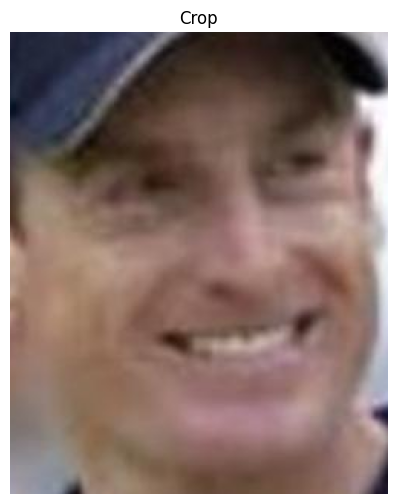

In [101]:
img_path = './Data/face_detection/test/images/man_9452.jpg'
crop = get_photo(img_path, det_model)


plt.figure(figsize=(10,6))
# plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.imshow(Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)))
plt.title('Crop')
plt.axis('off')
plt.show()

### Функция для отправки результатов

In [ ]:
def send_results(crop):
    person, conf = predict_image(crop)
    return person, conf
